<a href="https://colab.research.google.com/github/JacekPardyak/mnist.svg/blob/master/notebooks/MNIST_SVG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install svgpathtools

In [26]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
from svgpathtools import concatpaths, wsvg, Path, Line, CubicBezier, parse_path, svg2paths
from urllib.request import urlretrieve
path = "mnist.svg.npz"
url = "https://github.com/JacekPardyak/mnist.svg/raw/master/data/mnist.svg.npz"
urlretrieve(url, filename=path)
mnist  = np.load(path,encoding='latin1',allow_pickle=True)
mnist = np.concatenate((np.concatenate((mnist['train_data'].reshape(-1,1),
                                     mnist['train_labels'].reshape(-1,1)), axis = 1),
                     np.concatenate((mnist['test_data'].reshape(-1,1),
                                     mnist['test_labels'].reshape(-1,1)), axis = 1)), axis = 0)
mnist.shape

(70000, 2)

In [27]:
np.load(path,encoding='latin1',allow_pickle=True)['train_labels']

array([1, 1, 1, ..., 2, 2, 2])

In [28]:
# paths to curve-strings
# construct numeric tensor from svg path(s)
def curve_encoder(paths, num):
  paths = concatpaths(paths)
  for ind in range(len(paths)):
    if isinstance(paths[ind], Line):
      paths[ind] = CubicBezier(paths[ind][0], paths[ind][0], paths[ind][1], paths[ind][1])
  length = paths.length()
  l = [path.length()/length for path in paths]
  targets = [num*v for v in l]
  nums = [ int(v) for v in targets]
  while sum(nums) < num:
    residuals = [ t - v for t,v in zip(targets, nums) ]
    index = residuals.index( max(residuals) )
    nums[index] += 1
  res = Path()
  for ind in range(len(paths)):
    c = paths[ind]
    for i in reversed(range(1, nums[ind] + 1)):
      c0, c = c.split(t = 1 / i)
      res.append(c0)
  output = np.empty((0,8), int)
  for i in range(len(res)):
    row = np.array([res[i][0].real, res[i][0].imag, res[i][1].real, res[i][1].imag, res[i][2].real, res[i][2].imag, res[i][3].real, res[i][3].imag])
    output = np.row_stack((output, row))
 # print(nums)
  return output

def curve_decoder(tens):
  path = Path()
  for i in range(tens.shape[0]):
    row = CubicBezier(complex(tens[i,0], tens[i,1]),
                      complex(tens[i,2], tens[i,3]),
                      complex(tens[i,4], tens[i,5]),
                      complex(tens[i,6], tens[i,7]))
    path.append(row)
  return path

def get_paths(attributes):
  paths = []
  for attribute in attributes:
    path = parse_path(attribute['d']).scaled(1, -1).translated(complex(0, 280))
    paths = paths + [path]
  return paths

def display_paths(paths):
    wsvg(paths = paths, filename = f"output.svg", openinbrowser=False)
    display(SVG(filename = f"output.svg"))

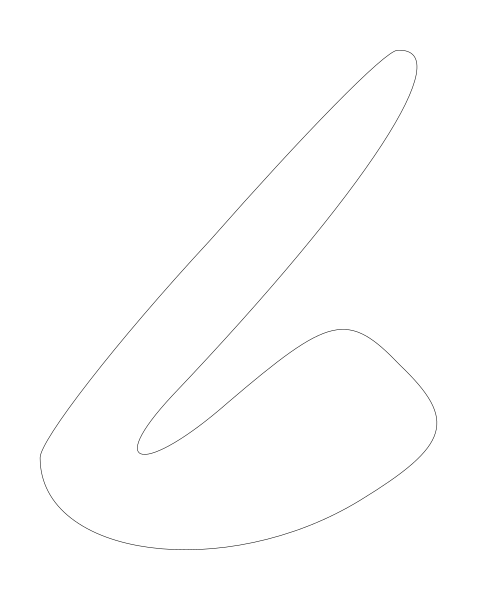

In [29]:
# random path - as is
attributes = np.random.choice(mnist[:,0], 1).tolist()[0]
paths = get_paths(attributes)
display_paths(paths)

In [30]:
# Filter digit paths with just one continous subpath
def is_worm(x):
    attributes = x[0]
    paths = get_paths(attributes)
    paths = concatpaths(paths)
    paths = paths.continuous_subpaths()
    if len(paths) == 1:
        ans = True
    else :
        ans = False
    return ans

mnist = np.column_stack(( mnist, np.apply_along_axis(is_worm, 1, mnist)))

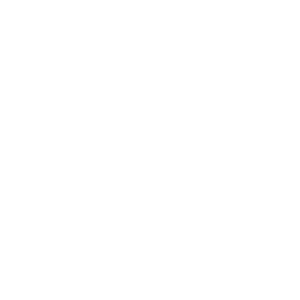

In [31]:
# pick random paths for each label
values = []
for label in range(10):
    tmp = mnist[mnist[:, 1] == label, ]
    tmp = tmp[tmp[:, 2] == True]
    attributes = np.random.choice(tmp[:,0], 1).tolist()[0]
    paths = get_paths(attributes)
#    display_paths(paths)
    paths = curve_decoder(curve_encoder(paths, num = 64))
    paths = paths.d()
    values.append(paths)
values.append(values[0])
values = ';\n'.join(values)

string = f'''<?xml version="1.0" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 20010904//EN"
 "http://www.w3.org/TR/2001/REC-SVG-20010904/DTD/svg10.dtd">
<svg version="1.0" xmlns="http://www.w3.org/2000/svg"
 width="300px" height="300px" viewBox="0 0 280 280"
 preserveAspectRatio="xMidYMid meet">
  <path d="">
  <animate
    dur='20s'
    attributeType="XML"
    attributeName='d'
    repeatCount='indefinite'
            values="{values}"
  />
    <animate
             attributeName="fill"
             dur="20s"
             repeatCount="indefinite"
             values="#E40303;#FF8C00;#FFED00;#008026;#24408E;#732982"
    />
    </path>
</svg>
'''

with open("morphing.svg", "w") as file:
    file.write(string)

display(SVG(filename = "morphing.svg"))